In [ ]:
# Data download from: [kaggle link]
# Important: need to share conda environment yaml and data download link at the end of the first session.

In [111]:
import glob
from torch.utils.data import DataLoader, Dataset
import torch
from torchvision import datasets, transforms
# from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
import re
import random
random.seed(123)

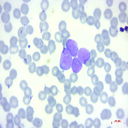

In [108]:
from PIL import Image
img_0 = Image.open(all_files[0])
img_0.resize((128, 128), Image.Resampling.LANCZOS)

# perhaps show loading images with opencv as well?

In [104]:
import numpy as np
import matplotlib.pyplot as plt
img_0 = np.asarray(img_0, dtype="int32") # explain why we need to do this


In [262]:
class DatasetBuilder(Dataset):
    # Simplify this or break it down better
    # Maybe no need to do all pre-processing in __init__
    def __init__(self, folder):
        files = glob.glob(f"{folder}/*.jpg")
        # read images
        self.images = [Image.open(x) for x in files]

        # resize images
        self.images = [x.resize((128, 128), Image.Resampling.LANCZOS)  for x in self.images]

        # convert to images to numpy arrays
        self.images = [np.asarray(x) for x in self.images]

        # normalize images - try with and without normalisation
        self.images = [((x/255.0)-0.5)/0.5 for x in self.images]
        
        # get labels from filenames
        self.labels = [re.sub('.*/(.*)-(\\d+).jpg', '\\1', x) for x in files]
        self.classes_dict = dict((key, val) for val, key in enumerate(set(self.labels)))
        self.labels = [self.classes_dict[x] for x in self.labels]
        print(f"{len(self.images)} files, {len(self.labels)} labels, {len(self.classes_dict)} classes")


    def __getitem__(self, i):
        return torch.tensor(self.images[i].astype(np.float32)).permute(2, 0, 1), torch.tensor(self.labels[i])

    def __len__(self):
        return len(self.images)

    def classes(self):
        return self.classes_dict



In [264]:
# Create dataset instance
datasetfromfiles = DatasetBuilder("../data/archive/Original/**")
dataclasses = datasetfromfiles.classes()

3256 files, 3256 labels, 4 classes


In [265]:
dataclasses

{'WBC-Malignant-Pro': 0,
 'WBC-Benign': 1,
 'WBC-Malignant-Early': 2,
 'WBC-Malignant-Pre': 3}

In [237]:
# Set batch size
batch_size = 32

# Split datasets
train_set, val_set, test_set = random_split(datasetfromfiles, [0.7, 0.15, 0.15])

# Create data loaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..1.0].


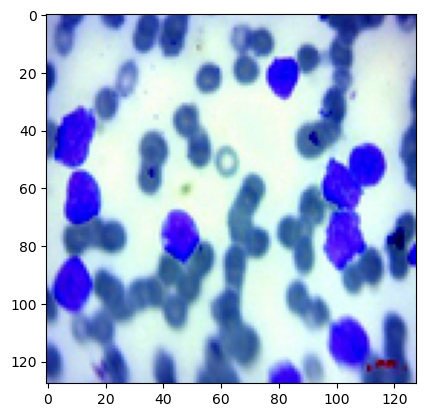

In [238]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Get a batch of training images
data_iter = iter(train_loader)

# Show images
plt.imshow(next(data_iter)[0][0].permute(1, 2, 0))



In [239]:
next(data_iter)[0].shape

torch.Size([32, 3, 128, 128])

In [240]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [241]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Pooling layer

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        # Third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # Adjust dimensions based on image size after convolutions
        self.fc2 = nn.Linear(128, num_classes)    # Output layer for the number of classes

    def forward(self, x):
        # Pass through first convolutional layer, apply activation and pooling
        x = self.pool(F.relu(self.conv1(x)))
        
        # Pass through second convolutional layer, apply activation and pooling
        x = self.pool(F.relu(self.conv2(x)))
        
        # Pass through third convolutional layer, apply activation and pooling
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the tensor for fully connected layers
        x = x.view(-1, 64 * 16 * 16)  # Flattening

        # Pass through first fully connected layer
        x = F.relu(self.fc1(x))
        
        # Output layer (no activation, as we'll apply CrossEntropyLoss during training)
        x = self.fc2(x)
        
        return x

# Todo - explain what a convolution is with simple example of vertical / horizontal filters


In [242]:
# Define the number of classes based on your dataset
num_classes = len(set(sorted(classes)))  # Adjust this based on your dataset

# Initialize the model
model = SimpleCNN(num_classes=num_classes)


In [243]:
import torch.optim as optim

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [246]:
# training loop
num_epochs = 10  # Set number of epochs for training; change this number to see how model works

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:  
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Print statistics
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training complete!")


Epoch [1/10], Loss: 0.1121
Epoch [2/10], Loss: 0.0826
Epoch [3/10], Loss: 0.0566
Epoch [4/10], Loss: 0.0466
Epoch [5/10], Loss: 0.0750
Epoch [6/10], Loss: 0.0232
Epoch [7/10], Loss: 0.0107
Epoch [8/10], Loss: 0.0105
Epoch [9/10], Loss: 0.0042
Epoch [10/10], Loss: 0.0016
Training complete!


In [247]:
# Model evaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:  
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Validation Accuracy: {accuracy:.2f}%')


Validation Accuracy: 93.65%


In [ ]:
# Todo
# Example of pre-trained model (e.g. Resnet)
# Example of pre-trained segmentation model?
# Exercise - try adding conv layers and see the effect on model performance
# Add other measures of model performance